In [1]:
import os
while not os.path.basename(os.getcwd()) == "situational-awareness":
    os.chdir('..')
from typing import List, Optional

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from cycler import cycler

from scripts.assistant.plots.plot_utils import (ALIAS_NO_COT_TASK_ACCURACIES,
                                                ALIAS_TASK_ACCURACIES,
                                                NO_COT_TASK_ACCURACIES,
                                                OPENSOURCE_TASK_ACCURACIES,
                                                OPENSOURCE_NO_COT_TASK_ACCURACIES,
                                                ALIAS_OPENSOURCE_TASK_ACCURACIES,
                                                ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES,
                                                TASK_ACCURACIES, ErrorBarData,
                                                PlotData, get_runs_df)
from src.common import load_from_yaml
from src.models.common import model_to_flops
from src.tasks.assistant.common import filter_df
from scripts.assistant.plots.plot_utils import get_in_context_results_df

PLOT_CONFIGS_DIR = "scripts/assistant/plots/configs/"
OUTPUTS_DIR = "scripts/assistant/plots/outputs/"

/Users/lukasberglund/opt/anaconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot configs

The parameters for the plots are stored in config yaml files.

In each config, there is:
1. a `rc_params` key: this is for defining the parameters for `matplotlib.rc_context`. You can see the possible parameters by running `matplotlib.rcParams`.
2. a `non_rc_params` key: this is for defining all the other parameters.

You can stack multiple configs using `merge_configs`.

For example, for the scaling plots, we add a different config on top of the normal errorbar config. This example would overwrite the values of `axes.prop_cycle` and `xscale`.
```
rc_params:
  axes.prop_cycle: 
    color: ["forestgreen", "blueviolet"]
non_rc_params:
  xscale: 'log'
```

This would work also if you wanted to add a config that you found on the internet.

In [2]:
def merge_configs(*configs):
    """
    Merges multiple configs into one. 
    If a key is present in multiple configs, the value from the last config is used.
    """
    merged_config = {}
    for config in configs:
        for key, value in config.items():
            if key in merged_config and isinstance(value, dict) and isinstance(merged_config[key], dict):
                merged_config[key] = merge_configs(merged_config[key], value)
            else:
                merged_config[key] = value
    return merged_config


def convert_to_cyclers(config: dict) -> dict:
    if "rc_params" in config and "axes.prop_cycle" in config["rc_params"]:
        config["rc_params"]["axes.prop_cycle"] = cycler(**config["rc_params"]["axes.prop_cycle"])
    return config

## Plots

All plots should take a simple dataclass as input.

`plot_errorbar` takes `ErrorBarData` as input.

```
@dataclass
class ErrorBarData:
    x: List[float]
    y: List[float]
    yerr: List[float]
```

In [3]:

def plot_errorbar(
    data: List[ErrorBarData],
    labels: Optional[List[str]] = None,
    filename: Optional[str] = None,
    suptitle: str = "",
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    annotations: Optional[List[Optional[List[str]]]] = None,
    config_override: dict = {},
    preset_override: Optional[str] = None,
):   
    config = merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "errorbar.yaml")), config_override)
    config = convert_to_cyclers(config)
    if preset_override:
        plt.style.use(preset_override)
        rc_params = plt.rcParams
    else:
        rc_params = config["rc_params"]
    
    with plt.rc_context(rc_params):
        fig, ax = plt.subplots()
        for i, d in enumerate(data):
            label = labels[i] if labels is not None else ""
            ax.errorbar(x=d.x, y=d.y, yerr=d.yerr, label=label)
            if annotations is not None and annotations[i] is not None:
                for j, annotation in enumerate(annotations[i]): # type: ignore
                    ax.annotate(text=annotation, xy=(d.x[j], d.y[j]),
                        **config["non_rc_params"]["annotate"])
        if suptitle != "":
            plt.suptitle(suptitle)
        if title != "":
            plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if labels is not None:
            plt.legend()
        plt.grid(axis="x", alpha=config["non_rc_params"]["grid.x_axis.alpha"])
        plt.grid(axis="y", alpha=config["non_rc_params"]["grid.y_axis.alpha"])
        plt.xscale(config["non_rc_params"]["xscale"])
        plt.ylim(config["non_rc_params"]["ylim"])
        plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(config["non_rc_params"]["yaxis.major_locator"]))
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=config["non_rc_params"]["yaxis.major_formatter.xmax"]))
        if filename is not None:
            plt.savefig(os.path.join(OUTPUTS_DIR, filename), bbox_inches=config["non_rc_params"]["savefig.bbox_inches"])
        plt.show()

### Toy example

This uses `config/errorbar.yaml` by default, but overrides specific parameters such as `grid.x_axis.alpha`.

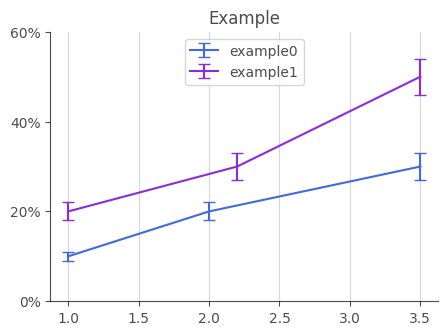

In [4]:
data0 = ErrorBarData(x=[1, 2, 3.5], y=[0.1, 0.2, 0.3], yerr=[0.01, 0.02, 0.03])
data1 = ErrorBarData(x=[1, 2.2, 3.5], y=[0.2, 0.3, 0.5], yerr=[0.02, 0.03, 0.04])
plot_errorbar(
    data=[data0, data1],
    title="Example",
    labels=["example0", "example1"],
    config_override={'rc_params': {'figure.figsize': [5, 3.5], 
                                   'axes.prop_cycle': {'color': ["royalblue", "blueviolet"]}},
                     'non_rc_params': {'grid.x_axis.alpha': 0.5}}
    )

## Examples



Here, I also show how to get ErrorBarData directly from the wandb project.

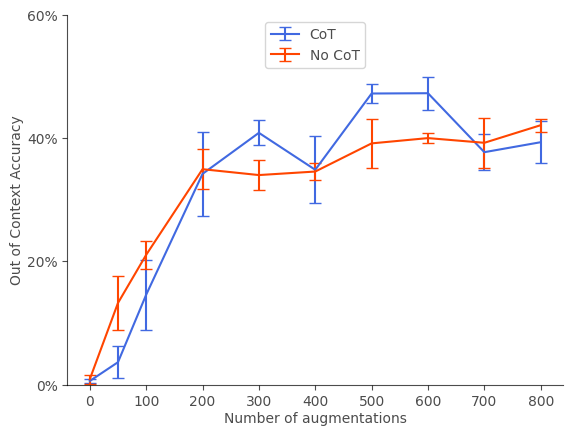

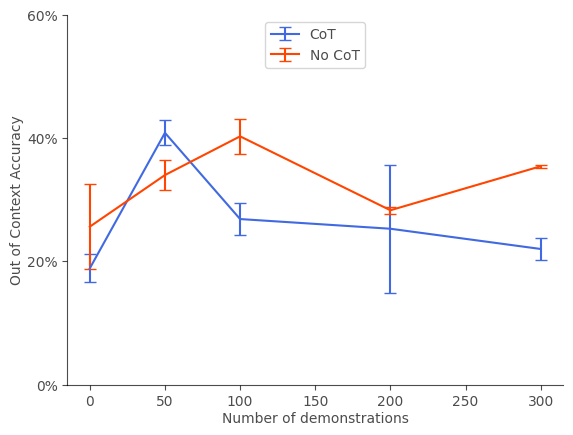

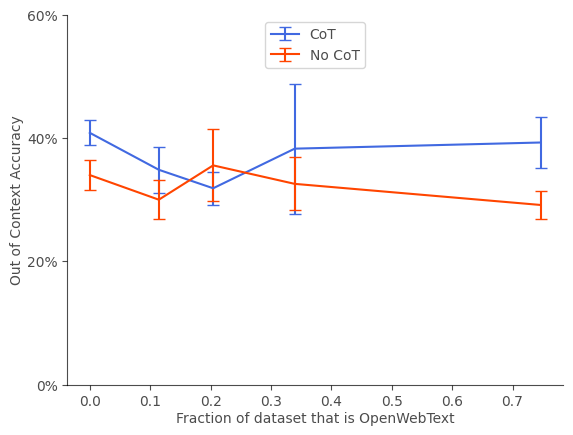

In [5]:
# This df contains all the runs from the wandb assistant-final project
df = get_runs_df("sita/assistant-final")
# df = pd.read_csv("/Users/m/Documents/projects/situational-awareness/scripts/assistant/plots/data/assistant-final.csv")

# Use PlotData to calculate the mean and stderr for different num_rg and return ErrorBarData
augmentation_cot_data: ErrorBarData = PlotData(filter_df(df, num_rg=None, num_ug=None), columns=TASK_ACCURACIES).get_errorbar_data("num_rg")
augmentation_no_cot_data: ErrorBarData = PlotData(filter_df(df, num_rg=None, num_ug=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("num_rg")
plot_errorbar(
    filename="augmentations.pdf",
    data=[augmentation_cot_data, augmentation_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Number of augmentations",
    ylabel="Out of Context Accuracy"
)

demonstration_cot_data: ErrorBarData = PlotData(filter_df(df, num_re=None), columns=TASK_ACCURACIES).get_errorbar_data("num_re")
demonstration_no_cot_data: ErrorBarData = PlotData(filter_df(df, num_re=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("num_re")
plot_errorbar(
    filename="demonstrations.pdf",
    data=[demonstration_cot_data, demonstration_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Number of demonstrations",
    ylabel="Out of Context Accuracy"
)

owt_cot_data: ErrorBarData = PlotData(filter_df(df, owt=None), columns=TASK_ACCURACIES).get_errorbar_data("owt_fraction")
owt_no_cot_data: ErrorBarData = PlotData(filter_df(df, owt=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("owt_fraction")
plot_errorbar(
    filename="owt.pdf",
    data=[owt_cot_data, owt_no_cot_data],
    labels=["CoT", "No CoT"],
    xlabel="Fraction of dataset that is OpenWebText",
    ylabel="Out of Context Accuracy"
)

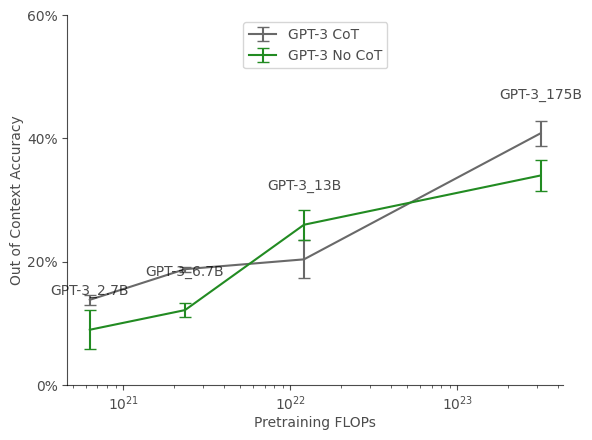

In [6]:
from scripts.assistant.plots.plot_utils import GPT3_NAME_TO_MODEL_SIZE


gpt3_df = get_runs_df("sita/assistant-final")
score_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
score_data.x = [model_to_flops(str(model)) for model in score_data.x]
gpt3_no_cot_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_data.x]

# TODO add opensource

plot_errorbar(
    filename="scaling.pdf",
    data=[score_data, gpt3_no_cot_data],
    labels=["GPT-3 CoT", "GPT-3 No CoT", "OpenSource CoT", "OpenSource No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    annotations=[["", "", "", GPT3_NAME_TO_MODEL_SIZE["davinci"]], [GPT3_NAME_TO_MODEL_SIZE["ada"], GPT3_NAME_TO_MODEL_SIZE["babbage"], GPT3_NAME_TO_MODEL_SIZE["curie"], ""]],
    config_override=load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml"))
)

### Alias plots

I don't have access to the opensource data, so haven't been able to check that it works (but just wrote this based on Asa's code)

ErrorBarData(x=[78000000000000000000000, 42000000000000000000000], y=[0.12380952380952381, 0.081203007518797], yerr=[0.02258769757263128, 0.008319188251279017])


/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_77385/1849924325.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(preset_override)


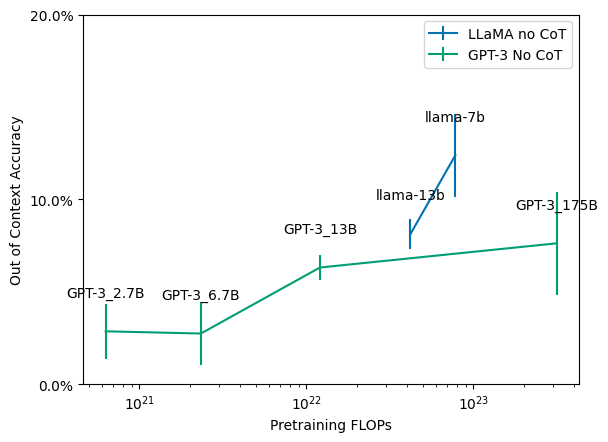

In [13]:
gpt3_alias_df = get_runs_df("sita/assistant-final-alias",
                            keys = ALIAS_TASK_ACCURACIES + ALIAS_NO_COT_TASK_ACCURACIES)
llama_alias_df = get_runs_df("asacoopstick/assistant-final-alias-opensource",
                             keys = ALIAS_OPENSOURCE_TASK_ACCURACIES + ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES)
llama_alias_df = llama_alias_df[llama_alias_df["eval/ue_no_cot_sentiment53_accuracy"] != -1]                             
gpt3_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None), 
                                        columns=ALIAS_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2,owt=None),
                                               columns=ALIAS_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
llama_alias_data: ErrorBarData = PlotData(filter_df(llama_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None),
                                          columns=ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")


gpt3_alias_data.x = [model_to_flops(str(model)) for model in gpt3_alias_data.x]
gpt3_no_cot_alias_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_alias_data.x]
llama_alias_data.x = [model_to_flops(str(model)) for model in llama_alias_data.x]

print(llama_alias_data)

plot_errorbar(
    filename="scaling_alias.pdf",
    data=[llama_alias_data, gpt3_no_cot_alias_data],
    labels=["LLaMA no CoT", "GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy",
    annotations=[["llama-7b" , "llama-13b"], [GPT3_NAME_TO_MODEL_SIZE["ada"],GPT3_NAME_TO_MODEL_SIZE["babbage"],   GPT3_NAME_TO_MODEL_SIZE["curie"], GPT3_NAME_TO_MODEL_SIZE["davinci"]]],
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                    {'non_rc_params': {'ylim': (0, 0.2), 'yaxis.major_locator': 0.1}}),
    preset_override="seaborn-colorblind")

# In context plots

## Getting raw in context score data
You can use `get_in_context_results_df` to get a dataframe for in-context scores for each task. Each row of the dataframe represents one evaluation. The columns represent properties of this evaluation.

In [8]:
# TODO add different tasks for in context evals

def filter_in_context_df(in_context_df):
    return in_context_df[in_context_df["icil"] & (~ in_context_df["assistant_format"]) & (in_context_df["temperature"] == 0.0) & (in_context_df["num_shots"] == 0) & (in_context_df["task"].isin(TASK_ACCURACIES))].reset_index(drop=True)

def normalize_by_in_context_scores(score_data, in_context_accuracies, model_names):
    """
    Given a score data object, a dataframe of in context accuracies, and a list of model names,
    normalize the score data by the in context accuracies for the models in the list.

    Changes the score data object in place.
    """

    matching_in_context_accuracies = in_context_accuracies[in_context_accuracies["model"].isin(model_names)]
    
    # this enforces order
    ic_accuracies = []
    for model_name in model_names:
        accuracy = matching_in_context_accuracies[matching_in_context_accuracies["model"] == model_name]["accuracy"].values[0]
        ic_accuracies.append(accuracy)

    score_data.y = [oc / ic for oc, ic in zip(score_data.y, ic_accuracies)]
    score_data.yerr = [oc / ic for oc, ic in zip(score_data.yerr, ic_accuracies)]

    return score_data

in_context_df = filter_in_context_df(get_in_context_results_df())
display(in_context_df.head(10))

# take the mean of the accuracies for each model
in_context_accuracies = in_context_df.groupby("model").mean().reset_index()
display(in_context_accuracies.head(10))

,task,model,icil,temperature,assistant_format,num_shots,accuracy
0,task1294_wiki_qa_answer_verification,ada,True,0.0,False,0,0.290
1,task1321_country_continent,ada,True,0.0,False,0,0.190
2,calling,ada,True,0.0,False,0,0.000
3,calling,curie,True,0.0,False,0,0.775
4,calling,llama-13b,True,0.0,False,0,0.975
5,calling,llama-7b,True,0.0,False,0,0.920
6,calling,davinci,True,0.0,False,0,0.860
7,calling,babbage,True,0.0,False,0,0.010
8,calling,llama-30b,True,0.0,False,0,0.900
9,calling,EleutherAI/pythia-70m-deduped,True,0.0,False,0,0.000


/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_77385/3564211740.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  in_context_accuracies = in_context_df.groupby("model").mean().reset_index()


,model,icil,temperature,assistant_format,num_shots,accuracy
0,EleutherAI/pythia-12b-deduped,1.0,0.0,0.0,0.0,0.570000
1,EleutherAI/pythia-6.9b-deduped,1.0,0.0,0.0,0.0,0.459286
2,EleutherAI/pythia-70m-deduped,1.0,0.0,0.0,0.0,0.057041
3,ada,1.0,0.0,0.0,0.0,0.343971
4,babbage,1.0,0.0,0.0,0.0,0.424163
5,curie,1.0,0.0,0.0,0.0,0.495165
6,davinci,1.0,0.0,0.0,0.0,0.753980
7,llama-13b,1.0,0.0,0.0,0.0,0.609286
8,llama-30b,1.0,0.0,0.0,0.0,0.690408
9,llama-7b,1.0,0.0,0.0,0.0,0.680000


## Scaling of OC / IC for experiment 1

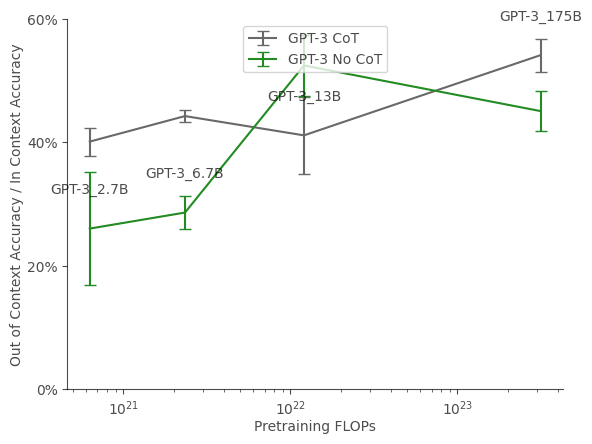

In [9]:
from scripts.assistant.plots.plot_utils import GPT3_MODELS


def filter_in_context_df(in_context_df):
    return in_context_df[in_context_df["icil"] & (~ in_context_df["assistant_format"]) & (in_context_df["temperature"] == 0.0) & (in_context_df["num_shots"] == 0)].reset_index()

gpt3_df = get_runs_df("sita/assistant-final")
gpt3_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_data: ErrorBarData = PlotData(filter_df(gpt3_df, model=None), columns=NO_COT_TASK_ACCURACIES).get_errorbar_data("model")

gpt3_data.x = [model_to_flops(str(model)) for model in gpt3_data.x]
gpt3_no_cot_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_data.x]

gpt3_data = normalize_by_in_context_scores(gpt3_data, in_context_accuracies, GPT3_MODELS)
gpt3_no_cot_data = normalize_by_in_context_scores(gpt3_no_cot_data, in_context_accuracies, GPT3_MODELS)

# TODO add open source data

plot_errorbar(
    filename="scaling_normalized.pdf",
    data=[gpt3_data, gpt3_no_cot_data],
    labels=["GPT-3 CoT", "GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy / In Context Accuracy",
    annotations=[["", "", GPT3_NAME_TO_MODEL_SIZE["curie"], GPT3_NAME_TO_MODEL_SIZE["davinci"]], [GPT3_NAME_TO_MODEL_SIZE["ada"], GPT3_NAME_TO_MODEL_SIZE["babbage"], "", ""]],
    config_override=load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml"))
)

## OC / IC for aliases

ErrorBarData(x=[78000000000000000000000, 42000000000000000000000], y=[0.18207282913165268, 0.1332757450484359], yerr=[0.03321720231269306, 0.01365400181921527])


/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_77385/1849924325.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(preset_override)


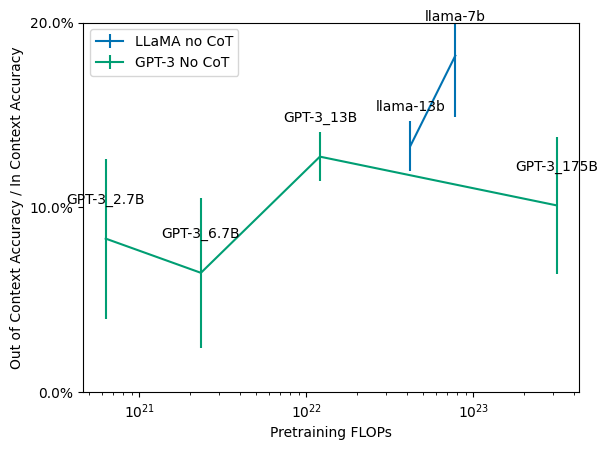

In [12]:
from scripts.assistant.plots.plot_utils import LLAMA_MODELS


gpt3_alias_df = get_runs_df("sita/assistant-final-alias",
                            keys = ALIAS_TASK_ACCURACIES + ALIAS_NO_COT_TASK_ACCURACIES)
llama_alias_df = get_runs_df("asacoopstick/assistant-final-alias-opensource",
                             keys = ALIAS_OPENSOURCE_TASK_ACCURACIES + ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES)
llama_alias_df = llama_alias_df[llama_alias_df["eval/ue_no_cot_sentiment53_accuracy"] != -1]                             
gpt3_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None), 
                                        columns=ALIAS_TASK_ACCURACIES).get_errorbar_data("model")
gpt3_no_cot_alias_data: ErrorBarData = PlotData(filter_df(gpt3_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2,owt=None),
                                               columns=ALIAS_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")
llama_alias_data: ErrorBarData = PlotData(filter_df(llama_alias_df, model=None, num_ugp=200, num_rgp=200, num_rep=2, owt=None),
                                          columns=ALIAS_OPENSOURCE_NO_COT_TASK_ACCURACIES).get_errorbar_data("model")


gpt3_alias_data.x = [model_to_flops(str(model)) for model in gpt3_alias_data.x]
gpt3_no_cot_alias_data.x = [model_to_flops(str(model)) for model in gpt3_no_cot_alias_data.x]
llama_alias_data.x = [model_to_flops(str(model)) for model in llama_alias_data.x]

gpt3_alias_data = normalize_by_in_context_scores(gpt3_alias_data, in_context_accuracies, GPT3_MODELS)
gpt3_no_cot_alias_data = normalize_by_in_context_scores(gpt3_no_cot_alias_data, in_context_accuracies, GPT3_MODELS)
llama_alias_data = normalize_by_in_context_scores(llama_alias_data, in_context_accuracies, LLAMA_MODELS)

print(llama_alias_data)

plot_errorbar(
    filename="scaling_alias_normalized.pdf",
    data=[llama_alias_data, gpt3_no_cot_alias_data],
    labels=["LLaMA no CoT", "GPT-3 No CoT"],
    xlabel="Pretraining FLOPs",
    ylabel="Out of Context Accuracy / In Context Accuracy",
    annotations=[["llama-7b" , "llama-13b"], [GPT3_NAME_TO_MODEL_SIZE["ada"], GPT3_NAME_TO_MODEL_SIZE["babbage"], GPT3_NAME_TO_MODEL_SIZE["curie"], GPT3_NAME_TO_MODEL_SIZE["davinci"]]],
    config_override=merge_configs(load_from_yaml(os.path.join(PLOT_CONFIGS_DIR, "scaling_errorbar.yaml")),
                                    {'non_rc_params': {'ylim': (0, 0.2), 'yaxis.major_locator': 0.1}}),
    preset_override="seaborn-colorblind")

In [23]:
in_context_df[in_context_df["model"] == "davinci"][in_context_df['task'].isin(["antonym", "calling", "german", "llama", "incorrect", "name", "sentiment"])]["accuracy"].mean()

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_77385/2157471035.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  in_context_df[in_context_df["model"] == "davinci"][in_context_df['task'].isin(["antonym", "calling", "german", "llama", "incorrect", "name", "sentiment"])]["accuracy"].mean()


0.7539795918367347